# Overview  
## Purpose  
This notebook provides a walkthrough of a "vanilla" analysis of scRNAseq data in scanpy. I've outlined some of the most general questions that a biologist may want to ask of the dataset, with comments for biological context and demo visualizations for each. This is intended to outline the "paths" a biologist may want to take through the cellxgene app, and scope out the most important questions for the tool to be able to address easily.  
  
Importantly, this analysis is replicated [here](URL here) using cellxgene for as many steps as possible. I've outlined the comparison [here](URL here).  
  
## Analytical steps  
For each dataset, a standard analytical workflow may look like:  
1. Characterize the shape of the raw data  
2. Normalize the data  
3. Look at the distribution of the dataset overall. For high-dimensional datasets, this includes dimensionality reduction.  
4. Look at rows (cells): are there clusters? How defined are they? Do they correspond to "ground truth" characterizations?  
5. Look at columns (genes): are there covarying sets of genes? What do they do? Do these groups "make sense" biologically?  
6. Look at the relationship between rows (cells) and columns (genes): for a given cluster of cells, what genes make their expression profiles different from other cells? For a given gene, which cells express that gene? 

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex
%matplotlib inline
import scanpy.api as sc
import math
import random
from scipy import stats
from timeit import timeit

sns.set(style='whitegrid', palette='Set2', font_scale=1.3)

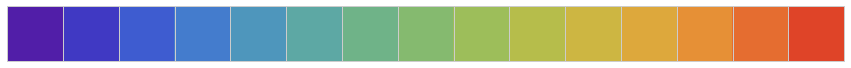

In [107]:
colors = ["#511EA8", "#482BB6", "#4039C3", "#3F4ACA", "#3E5CD0", "#416CCE", "#447CCD", "#4989C4", "#4E96BC", "#559FB0", "#5DA8A4", "#66AE96", "#6FB388", "#7AB77C", "#85BA6F", "#91BC64", "#9DBE5A", "#AABD53", "#B6BD4B", "#C2BA46", "#CDB642", "#D6B03F", "#DDA83C", "#E29D39", "#E69036", "#E67F33", "#E56D30", "#E2592C", "#DF4428", "#DC2F24"]
cmap = LinearSegmentedColormap.from_list('cmap', colors)
palette = sns.color_palette(colors[::2], n_colors=15)
sns.set(style='whitegrid', palette=palette, font_scale=1.2)

sns.palplot(palette)

def assign_colors(vals, cmap=cmap):
    ''' return a dictionary of { value: (R,G,B,a) } '''
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    vals = set(vals)
    nvals = len(vals)
    colors = [cmap(i/nvals) for i in range(nvals)]
    
    return { val: colors[i] for i,val in enumerate(vals) }

## 1. Load & characterize the raw data  

In [3]:
rawdata = sc.read('./data/Marrow-counts.csv').transpose() 
cell_annotation = pd.read_csv('./data/annotations_FACS.csv', index_col=0) 
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class

'''# metadata doesn't seem to match up to cell IDs, even when converting cell -> well IDs. 
This will be important later for batch correction, but we'll leave it alone for now.'''

# cell_metadata = pd.read_csv('./00_data_ingest/00_facs_raw_data/metadata_FACS.csv', index_col=0) 
# well_to_cell_ids = { k.split('.')[1] : k for k in cell_annotation.index.values }
# cell_metadata.rename(index=well_to_cell_ids, inplace=True)

"# metadata doesn't seem to match up to cell IDs, even when converting cell -> well IDs. \nThis will be important later for batch correction, but we'll leave it alone for now."

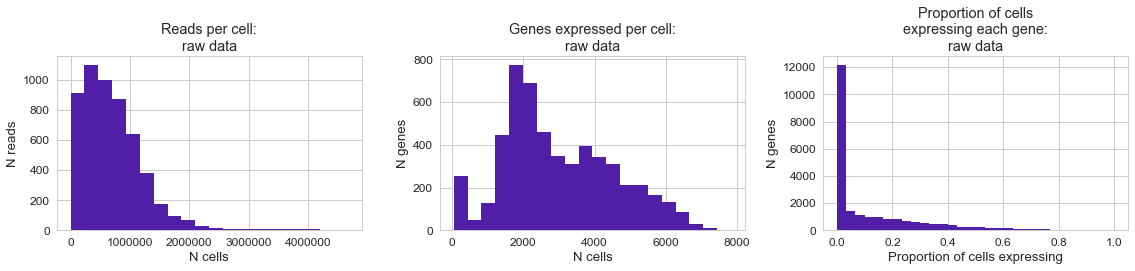

In [17]:
### Add a cell here with distrib of # genes / cell, # cells / gene before and after norm

df = pd.DataFrame(rawdata.X, index=rawdata.obs_names, columns=rawdata.var_names)
fig, ax = plt.subplots(ncols=3,nrows=1, figsize=(16,4))

reads_per_cell = df.sum(axis=1)
plt.sca(ax[0])
plt.hist(reads_per_cell.values, bins=20)
ax[0].set_title('Reads per cell:\nraw data')
ax[0].set_xlabel('N cells')
ax[0].set_ylabel('N reads')

nonzero = df.mask(df.values > 0, other=1)
genes_per_cell = nonzero.sum(axis=1)
plt.sca(ax[1])
plt.hist(genes_per_cell.values, bins=20)
ax[1].set_title('Genes expressed per cell:\nraw data')
ax[1].set_xlabel('N cells')
ax[1].set_ylabel('N genes')

pCells_per_gene = nonzero.sum(axis=0)/len(nonzero.index.values)
plt.sca(ax[2])
plt.hist(pCells_per_gene.values, bins=30)
ax[2].set_title('Proportion of cells\nexpressing each gene:\nraw data')
ax[2].set_ylabel('N genes')
ax[2].set_xlabel('Proportion of cells expressing')

plt.tight_layout()
plt.show()

## 2. Normalize the data: filter to informative cells & genes, center & scale data  
### This brings us to the point where cellxgene intercepts the user.

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.8 µs


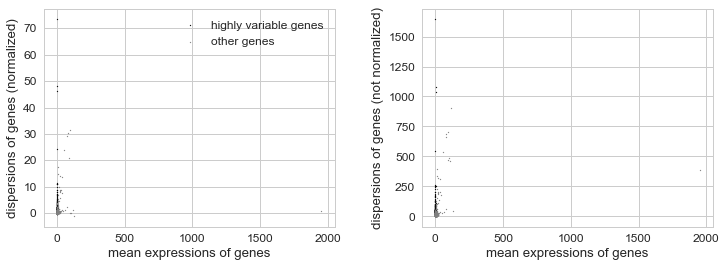

In [5]:
%time
'''
Their 'seurat' recipe for count normalization includes:
    pp.filter_cells(adata, min_genes=200) # drop cells with fewer than 200 genes expressed
    pp.filter_genes(adata, min_cells=3) # remove genes expressed in fewer than 3 cells
    pp.normalize_per_cell(adata, counts_per_cell_after=1e4) # each cell sums to 1
    filter_result = pp.filter_genes_dispersion(
        adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5, log=not log) # remove uninformative genes
    adata._inplace_subset_var(filter_result.gene_subset)  
    if log: pp.log1p(adata) # log scale
    pp.scale(adata, max_value=10) # center + scale
'''

adata = sc.pp.recipe_seurat(rawdata, plot=True, copy=True)

## 3. Look at the distribution of the dataset overall  
### To make this easier, we'll reduce dimensionality with PCA.

In [6]:
%time
sc.tl.pca(adata, n_comps=len(adata.var_names)) ## Run PCA and ask for *all* PCs

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


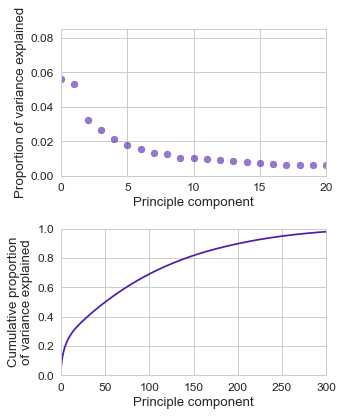

In [7]:
pca_var_explained = adata.uns['pca']['variance']
pca_var_explained = [ x / sum(pca_var_explained) for x in pca_var_explained ]

fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(5,6))
ax0.scatter(range(len(pca_var_explained)), pca_var_explained, alpha=0.6)
ax0.set_xlabel('Principle component')
ax0.set_ylabel('Proportion of variance explained')
ax0.set_ylim(0,)
ax0.set_xlim(0, 20)

cumulative_var_explained = [ sum(pca_var_explained[:i+1]) for i in range(len(pca_var_explained))]
ax1.plot(range(len(pca_var_explained)), cumulative_var_explained)
ax1.set_xlabel('Principle component')
ax1.set_ylabel('Cumulative proportion\nof variance explained')
ax1.set_xlim(0,300)
ax1.set_ylim(0,1)
plt.tight_layout()

## 4. Look at rows (cells)  
### Are there clusters? How defined are they? Do they correspond to "ground truth" characterizations?

In [9]:
## Clustering 
'''
Scanpy uses PhenoGraph, an implementation of Louvain modularity, to infer "networks" of cells from the Jaccard graph.
Ref: https://www.cell.com/cms/attachment/2061927522/2063377372/mmc1.pdf'''

'''first compute the Jaccard graph of cell similarity, which is similar to kNN but with edges 
weighted by the similarity of each cell's individual group of kNN '''
print('Dataset size: ', adata.X.shape)

%time sc.pp.neighbors(adata,metric='euclidean', random_state=2018) 
%time sc.tl.louvain(adata, random_state=2018) # Then use the Louvain algorithm to identify clusters
adata.obs['louvain'] = adata.obs['louvain'].astype(str)

Dataset size:  (5242, 402)
CPU times: user 1.67 s, sys: 450 ms, total: 2.12 s
Wall time: 1.56 s
CPU times: user 355 ms, sys: 8.63 ms, total: 364 ms
Wall time: 365 ms


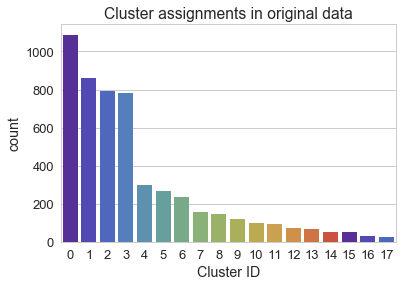

<Figure size 432x288 with 0 Axes>

In [56]:
ax = sns.countplot(adata.obs['louvain'], order = adata.obs['louvain'].value_counts().index, palette=palette)
ax.set_xlabel('Cluster ID')
ax.set_title('Cluster assignments in original data')
plt.show()
plt.clf()

def downsample_by_cluster(adata, proportion=0.5, cluster_key = 'louvain'):
    '''Cluster-informed downsampling of cells in an anndata object
       adata: anndata object
       proportion: proportion of cells from each cluster to KEEP
       cluster_key: where to find cluster IDs in adata.obs[]
       returns adata[subsample,:]
    '''
    
    if proportion == 1:
        return adata
    
    assert 0 < proportion < 1
    assert cluster_key in adata.obs.columns.values, 'Oops. Run clustering first with sc.pp.neighbors -> sc.tl.louvain'

    all_selected = []
    clusters = adata.obs.groupby('louvain')

    for cluster, cells in clusters.groups.items():
        N_cells = len(cells)
        choose_k = int(N_cells*proportion)
        selected = random.sample(list(cells), k=choose_k)
        all_selected += selected

    return adata[all_selected, :]

### Downsample to 30%, 50%, 70%, and 100% of original data size.
total_N = len(adata.obs)
dataset_scales = { int(p*total_N) : downsample_by_cluster(adata, p) for p in [0.1, 0.3,0.5,0.7,1] }

In [111]:
### Add a cell here showing the distributions of cell types per cluster and vice versa

In [ ]:
def time_per_dataset(fn, dataset_scales=dataset_scales, title=None):
    time = { size: timeit(lambda : fn(dataset), number=1) for size, dataset in dataset_scales.items() }
    fig, ax = plt.subplots()
    x,y=list(zip(*time.items()))
    ax.scatter(x,y)
    ax.set_xlabel('Number of cells')
    ax.set_ylabel('Execution time (seconds)')
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
    

## Scanpy clustering & parameters  
### Scanpy includes only one method for clustering, `sc.tl.louvain`, which implements the louvain algorithm to assign cells to clusters based on the k-nearest-neighbors graph first built with `sc.pp.neighbors`.  
  
#### `sc.pp.neighbors` parameters to expose to user:  
* n_neighbors: int  
* n_pcs: int  
* method: str {'umap', 'gauss'}  

#### `sc.pp.neighbors` parameters to fix:  
* knn: True
* random_state: int # should be the same for the entire working session
* metric: 'euclidean'   
_`pp.neighbors` also allows knn=False --> compute with Gaussian Kernel instead of hard cutoff at `k` neighbors, and it allows any metric accepted by scipy.spatial.distance.pdist, e.g. `jaccard`. However, tSNE apparently uses a separately computed kNN graph using `euclidean` distances. For consistency, it seems simplest to fix these two parameters (`knn` and `metric`) behind the scenes for now.  
  
#### `sc.tl.louvain` parameters to expose to user:  
* resolution: float  
  
#### `sc.tl.louvain` parameters to fix:  
* flavor: 'vtraag' (more powerful option for computing clustering)  
* random_state: int # should be the same for the entire working session  

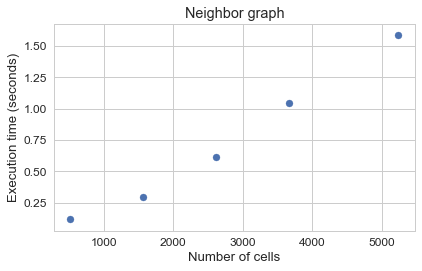

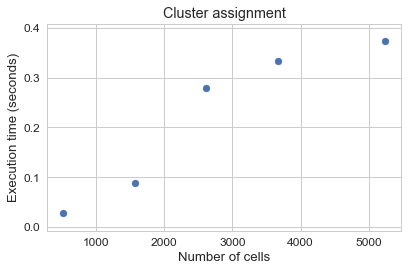

In [110]:
time_per_dataset(sc.pp.neighbors, title='Neighbor graph')
time_per_dataset(sc.tl.louvain, title='Cluster assignment')

## Dimensionality reduction ("layout")  
### Scanpy provides several options for embeddings, most notably the four listed below.  
  
### Method-specific parameters to expose:  
* tSNE: perplexity (float), learning_rate (float)  
* umap: min_dist (float), spread (float), alpha (float), gamma (float) _[maybe also `init_pos`?]  
* _PCA: None; defaults appropriate[?]_  
* _diffmap: None (all pulled from `neighbors`)_

### Shared parameters to fix:  
* Random state (should be the same for the entire work session)  
* n_components = 2 (for representation in 2D)  

In [112]:
## We can use cluster-informed downsampling to improve performance downstream.

demo = dataset_scales[1572]
sc.pp.pca(demo)
sc.pp.neighbors(demo)
sc.tl.tsne(demo)

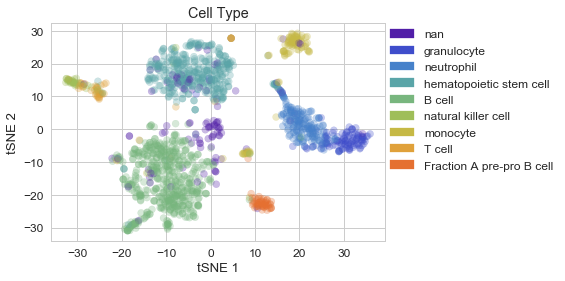

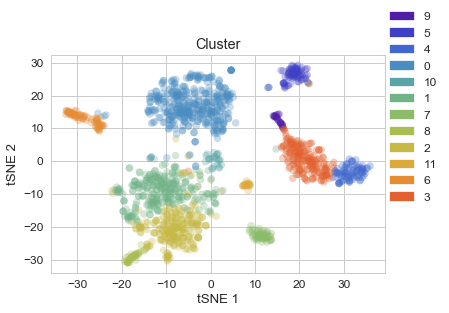

In [113]:
def plot_tsne(adata, colorby, title=None, cmap=cmap):
    ''' Plot tSNE colored by metadata field indicated in colorby. 
        Expects to find tSNE coordinates in adata.obsm['X_tsne'] 
        and metadata in adata.obs[colorby]'''
    
    sns.set(style='whitegrid', font_scale=1.2)
    fig, ax = plt.subplots()
    x = adata.obsm['X_tsne'][:,0]
    y = adata.obsm['X_tsne'][:,1]
    color_map = assign_colors(pd.unique(adata.obs[colorby]), cmap)
    colors = [color_map[x] if x in color_map else (.211,.211,.211,0.1) for x in adata.obs[colorby].values ]
    ax.scatter(x, y, c=colors, alpha=0.3)
    ax.set_xlabel('tSNE 1')
    ax.set_ylabel('tSNE 2')
    
    legend_handles = []
    for val, color in color_map.items():
        patch = mpatches.Patch(color=color, label=val)
        legend_handles.append(patch)
    plt.legend(loc=(1,.3),handles=legend_handles)
    
    if title:
        ax.set_title(title)
    plt.show()

plot_tsne(dataset_scales[1572], colorby='cell_type', title='Cell Type', cmap=cmap)
plot_tsne(dataset_scales[1572], colorby='louvain', title='Cluster', cmap=cmap)

## 5. Look at columns (genes)  
### Are there covarying sets of genes? What do they do? Do these groups "make sense" biologically?  
  
#### [Add this later]

### 6. Look at the relationship between columns (genes) and rows (cells)  
#### Which genes are differentially expressed in a given cell cluster?  
#### Which cells express my-favorite-gene?  


#### Scanpy does not provide a method for computing differential expression.  
Ambrose recommends [MAST](https://bioconductor.org/packages/release/bioc/html/MAST.html), but notes this is a very slow computation. In the mean time, the following is a nice ttest implementation pulled from Charlotte's cellxgene-rest-api code  

In [114]:
def diffexp(expression_1, expression_2, genes, pval=0.001, num_genes=20):
    """
    get top expressed genes from two different cell sets (uses t-test)
    :param expression_1: numpy expression array cell set 1
    :param expression_2: numpy expression array cell set 2
    :param pval: stats limit
    :param num_genes: number of genes to limit results to
    :return: Top genes and mean expression, pvalue, and average difference
     between cell set1 to cell set 2 for each gene in both cell sets
     sorted by t-test value
    """
    diff_exp = stats.ttest_ind(expression_1, expression_2)
    set1 = np.logical_and(diff_exp.pvalue < pval, diff_exp.statistic > 0)
    set2 = np.logical_and(diff_exp.pvalue < pval, diff_exp.statistic < 0)
    stat1 = diff_exp.statistic[set1]
    stat2 = diff_exp.statistic[set2]
    sort_set1 = np.argsort(stat1)[::-1]
    sort_set2 = np.argsort(stat2)
    pval1 = diff_exp.pvalue[set1][sort_set1]
    pval2 = diff_exp.pvalue[set2][sort_set2]
    mean_ex1_set1 = np.mean(expression_1[:, set1], axis=0)[sort_set1]
    mean_ex2_set1 = np.mean(expression_2[:, set1], axis=0)[sort_set1]
    mean_ex1_set2 = np.mean(expression_1[:, set2], axis=0)[sort_set2]
    mean_ex2_set2 = np.mean(expression_2[:, set2], axis=0)[sort_set2]
    mean_diff1 = mean_ex1_set1 - mean_ex2_set1
    mean_diff2 = mean_ex1_set2 - mean_ex2_set2
    genes_cellset_1 = np.array([genes[idx] for idx, val in enumerate(set1) if val])[sort_set1]
    genes_cellset_2 = np.array([genes[idx] for idx, val in enumerate(set2) if val])[sort_set2]
    return {
        "celllist1": {
            "topgenes": genes_cellset_1.tolist()[:num_genes],
            "mean_expression_cellset1": mean_ex1_set1.tolist()[:num_genes],
            "mean_expression_cellset2": mean_ex2_set1.tolist()[:num_genes],
            "pval": pval1.tolist()[:num_genes],
            "ave_diff": mean_diff1.tolist()[:num_genes]
        },
        "celllist2": {
            "topgenes": genes_cellset_2.tolist()[:num_genes],
            "mean_expression_cellset1": mean_ex1_set2.tolist()[:num_genes],
            "mean_expression_cellset2": mean_ex2_set2.tolist()[:num_genes],
            "pval": pval2.tolist()[:num_genes],
            "ave_diff": mean_diff2.tolist()[:num_genes]
        },
    }

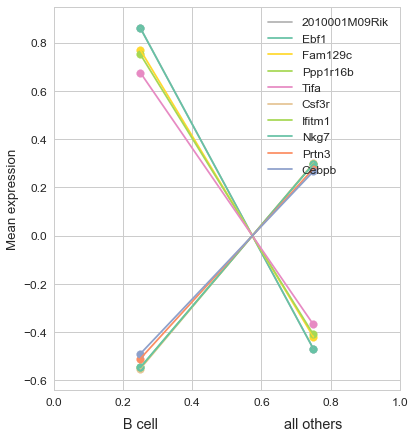

In [115]:
def compare_cell_sets(adata, cluster1_label, cluster2_label=None, cluster_key='louvain'):
    idx1 = adata.obs[cluster_key] == cluster1_label
    cluster1 = adata.X[idx1]
    
    if not cluster2_label:
        idx2 = adata.obs[cluster_key] != cluster1_label ## If no second set provided, compare to all others
        cluster2_label='all others'
    else:
        idx2 = adata.obs[cluster_key] == cluster2_label
    cluster2 = adata.X[idx2]
    
    genes = adata.var_names
    full_de = diffexp(cluster1, cluster2,genes=genes, num_genes=5)
    de = pd.DataFrame(full_de['celllist1']).append(pd.DataFrame(full_de['celllist2']))
    de.rename(columns={'mean_expression_cellset1': cluster1_label, 
                       'mean_expression_cellset2': cluster2_label},
             inplace=True)    
    de = de.set_index('topgenes')

    fig, ax = plt.subplots(figsize=(6, 6))
    pval_cutoff = 0.001
    
    colors = assign_colors(set(de.index.values), 'Set2')
    for gene, vals in de.iterrows():
        c = colors[gene]
        x1, x2 = 0.25, 0.75
        y1, y2 = vals[cluster1_label], vals[cluster2_label]
        ax.scatter(x1, y1, s=60, c=c)
        ax.scatter(x2, y2, s=60, c=c)
        ax.plot([0.25, 0.75], [vals[cluster1_label], vals[cluster2_label]], c=c, label=gene)
        
    ax.text(0.25, -0.1, cluster1_label,transform=ax.transAxes, ha='center')
    ax.text(0.75,-0.1, cluster2_label, transform=ax.transAxes, ha='center')
    ax.set_ylabel('Mean expression')
    plt.legend(loc=1)
        
    ax.set_xlim(0,1)
    plt.tight_layout()
    plt.show()
    return full_de

# compare_cell_sets(adata, '0', None)

B_cell_de = compare_cell_sets(adata, 'B cell', cluster_key='cell_type')

In [118]:
B_cell_enriched_genes = B_cell_de['celllist1']['topgenes']

In [ ]:
## Eventually, add a cell here showing gene ontology terms for enriched genes. 

## Perhaps also try a GO enrichment analysis on the counts matrix (i.e., which processes are upregulated in cell type X)

In [ ]:
## Then add a cell doing trajectory analysis